In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error

from keras.losses import MeanAbsolutePercentageError
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import layers
from datetime import datetime
from keras.datasets import mnist
from keras.layers import Dense, LSTM

In [2]:
# CLUSTER 0
df = pd.read_excel("Walmart_clusters.xlsx")
class_0 = df[df["cluster_sklearn"] == 0]

In [3]:
x1 = pd.to_numeric(class_0["Weekly_Sales"], errors="coerce").to_numpy()
x2 = pd.to_numeric(class_0["Temperature"], errors="coerce").to_numpy()
x3 = pd.to_numeric(class_0["Fuel_Price"], errors="coerce").to_numpy()
x4 = pd.to_numeric(class_0["CPI"], errors="coerce").to_numpy()
x5 = pd.to_numeric(class_0["Unemployment"], errors="coerce").to_numpy()
x6 = pd.to_numeric(class_0["yyyy"], errors="coerce").to_numpy()
x7 = pd.to_numeric(class_0["mm"], errors="coerce").to_numpy()
x8 = pd.to_numeric(class_0["dd"], errors="coerce").to_numpy()
x9 = pd.to_numeric(class_0["week_absolute"], errors="coerce").to_numpy()
x10 = pd.to_numeric(class_0["Date"], errors="coerce").to_numpy()

In [4]:
scaler = MinMaxScaler()

x_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]
features = []

for i in x_list:
    i = scaler.fit_transform(i.reshape(-1,1))
    features.append(i)
    x = np.concatenate(features,  axis=1)


In [5]:
# zamiana danych na sekwencję, wymagają tego warstwy rekurencyjne
# długość sekwencji zależy od tego po jakiej ilości próbek w czasie chcemy aby rekurencja chodziła
def ConvertDataToSequence(data, windowLen, featNum):
    """
    :param data: dane w postaci szeregu, typu numpy.array, shape=(N,Feat)
    :param windowLen: długość okna czyli długość sekwencji
    :param featNum: ilość cech w ramach szeregu
    """
    #długość wejściowego szeregu
    lenOfAllSeq = data.shape[0]
    # pusty kontener na kolejne sekwencje
    xSeq = []
    # idziemy po szeregu i tworzymy z niego sekwencje
    for i in range(lenOfAllSeq-windowLen):
        xSeq.append(data[i:i+windowLen])
    xSeq = np.array(xSeq).reshape(-1,windowLen,featNum)
    
    # definiujemy wartości następujące po każdej sekwencji, będą to nasze wyjścia
    y = data[windowLen:,0].reshape(-1,1)
    
    return xSeq, y

In [6]:
seqLen = 14
featNum = 10
xSeq, y = ConvertDataToSequence(x, seqLen, featNum)
print(f"sequence shape: {xSeq.shape}")
print(f"output shape: {y.shape}")

sequence shape: (2807, 14, 10)
output shape: (2807, 1)


In [7]:
test_percent = 0.1

In [8]:
x_len = xSeq.shape[0]

In [9]:
x_train_num = int(x_len*(1.0-test_percent))
x_test_num = int(x_len*test_percent)

In [10]:
xSeq_train = xSeq[:x_train_num]
xSeq_test = xSeq[-x_test_num:]

In [11]:
y_train = y[:x_train_num]
y_test = y[-x_test_num:]

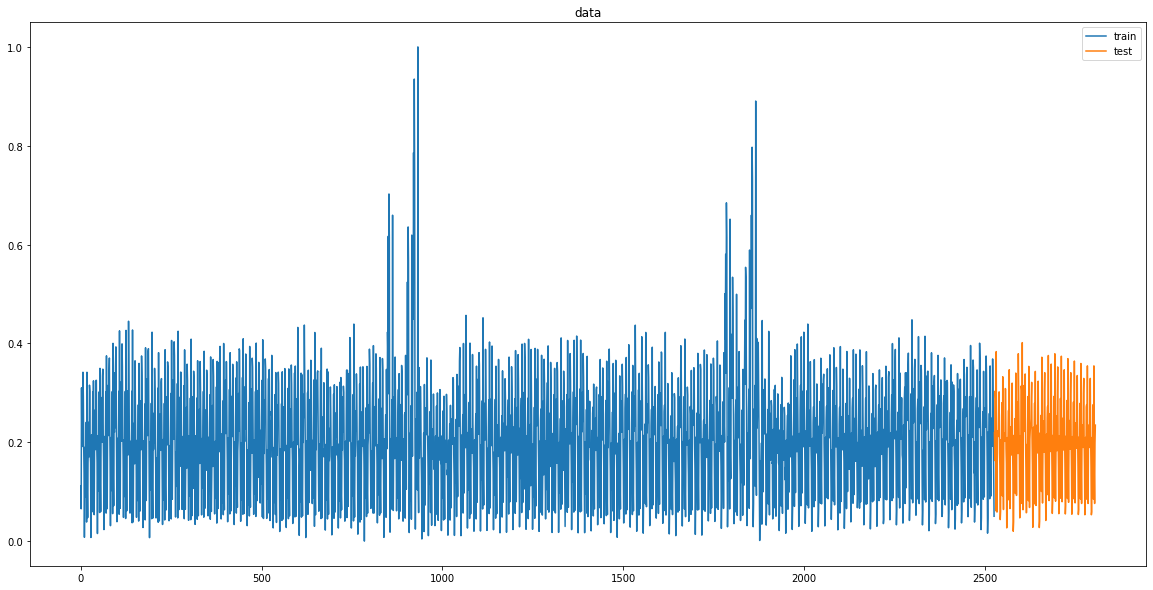

In [12]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(x_train_num), xSeq_train[:,0,0])
plt.plot(np.arange(x_train_num, x_len-1), xSeq_test[:,0,0])
plt.legend(["train","test"])
plt.title("data")
plt.show()

In [13]:
modelRNN = tf.keras.Sequential()

modelRNN.add(
    layers.LSTM(
        units=128,
        input_shape=(seqLen, featNum),
        name="rekurencja_pierwsza",
        return_sequences=True
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.LSTM(
        units=128,
        name="rekurencja_druga"
    )
)

modelRNN.add(
    layers.Dense(
        units=128,
        activation="relu"
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.Dense(
        units=1,
        name="wyjscie"
    )
)

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rekurencja_pierwsza (LSTM)  (None, 14, 128)           71168     
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 rekurencja_druga (LSTM)     (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 wyjscie (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,393
Trainable params: 219,393
Non-trai

In [22]:
modelRNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=MeanAbsolutePercentageError()
)

In [23]:
history = modelRNN.fit(
    x=xSeq_train,
    y=y_train,
    epochs=20,
    batch_size=4,
    validation_data=(xSeq_test, y_test),
    
)

Epoch 1/20
632/632 [==============================] - 12s 15ms/step - loss: 1264481.7500 - val_loss: 63.5420
Epoch 2/20
632/632 [==============================] - 9s 15ms/step - loss: 19449.7285 - val_loss: 74.3259
Epoch 3/20
632/632 [==============================] - 10s 15ms/step - loss: 43782.5391 - val_loss: 56.7241
Epoch 4/20
632/632 [==============================] - 10s 16ms/step - loss: 34380.2461 - val_loss: 85.8961
Epoch 5/20
632/632 [==============================] - 11s 17ms/step - loss: 26940.0723 - val_loss: 204.8627
Epoch 6/20
632/632 [==============================] - 11s 17ms/step - loss: 30002.7656 - val_loss: 166.0900
Epoch 7/20
632/632 [==============================] - 11s 18ms/step - loss: 105573.1016 - val_loss: 310.5972
Epoch 8/20
632/632 [==============================] - 11s 17ms/step - loss: 127403.2109 - val_loss: 75.4921
Epoch 9/20
632/632 [==============================] - 11s 18ms/step - loss: 25428.1133 - val_loss: 56.1604
Epoch 10/20
632/632 [==========

In [16]:
y_pred = modelRNN.predict(xSeq_test)

9/9 [==============================] - 1s 10ms/step


In [17]:
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))

0.1800666633426207
-20.092701958364284
2.6147063865570828


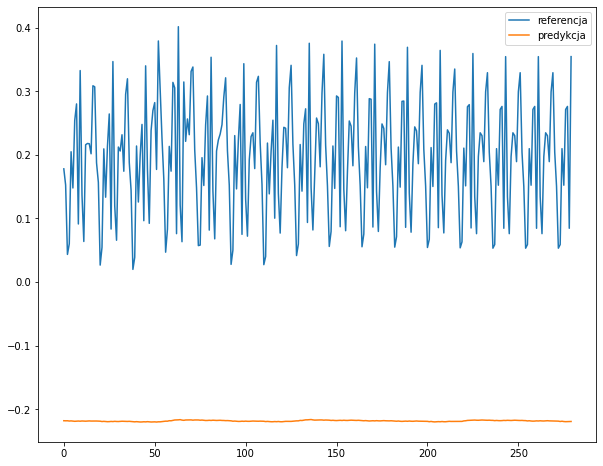

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(y_test)
plt.plot(y_pred.reshape(-1))

plt.legend(["referencja", "predykcja"])
plt.show()

In [19]:
rev_trans = scaler.inverse_transform(y_pred)

In [20]:
modelRNN.save("Projekt_DL/model_0.h5")